# 0. Preparation

In [2]:
if 'google.colab' in str(get_ipython()):
    IN_COLLAB = True
else:
    IN_COLLAB = False

if IN_COLLAB:
    #TODO: CHANGE THIS BASED ON YOUR OWN LOCAL SETTINGS
    MY_HOME_ABS_PATH = "/content/drive/MyDrive/W210/co2-flux-hourly-gpp-modeling"
    from google.colab import drive
    drive.mount('/content/drive/')
else:
    MY_HOME_ABS_PATH = "/root/co2-flux-hourly-gpp-modeling/"

## Import libraries

In [3]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")
import copy
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pytorch_lightning as pl
import torch
import torch.nn as nn

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting import BaseModel, MAE
from pytorch_forecasting.metrics.point import RMSE
from pytorch_forecasting.data.encoders import NaNLabelEncoder

from sklearn.metrics import r2_score
from timeit import default_timer
from datetime import datetime
import gc
import pickle

# Load locale custome modules
os.chdir(MY_HOME_ABS_PATH)
if IN_COLLAB:
     sys.path.insert(0,os.path.abspath("./code/src/tools"))
else:
    sys.path.append('./.cred')
    sys.path.append('./code/src/tools')
    sys.path.append(os.path.abspath("./code/src/tools"))

from CloudIO.AzStorageClient import AzStorageClient
from data_pipeline_lib import *
from model_pipeline_lib import *

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pl.seed_everything(42)
plt.rcParams['figure.figsize'] = [6, 3]

2023-04-02 23:46:03.645096: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-02 23:46:03.693455: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-02 23:46:03.694218: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 23:46:04.463056: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Global seed set to 42
Global seed set to 42


# Load data from Azure blob

In [4]:
root_dir =  MY_HOME_ABS_PATH
tmp_dir =  root_dir + os.sep + '.tmp'
model_dir = root_dir + os.sep + 'data' + os.sep + 'models'
cred_dir = root_dir + os.sep + '.cred'
az_cred_file = cred_dir + os.sep + 'azblobcred.json'

# Download full data
container = "all-sites-data"
blob_name = "full_2010_2015_v_mvp_raw.parquet"
local_file = tmp_dir + os.sep + blob_name

data_df = get_raw_datasets(container, blob_name)

Data size: (4862712, 51)
Data Columns: Index(['GPP_NT_VUT_REF', 'site_id', 'timestep_idx_local',
       'timestep_idx_global', 'datetime', 'date', 'year', 'month', 'day',
       'hour', 'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA',
       'PA_ERA', 'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6',
       'b7', 'IGBP', 'lat', 'long', 'koppen_sub', 'koppen_main', 'c3c4',
       'c4_percent', 'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily',
       'PET', 'Ts', 'ESACCI-sm', 'MODIS_LC', 'NDWI', 'Percent_Snow', 'Fpar',
       'Lai', 'LST_Day', 'LST_Night', 'MODIS_IGBP', 'MODIS_PFT',
       'gap_flag_hour', 'gap_flag_month'],
      dtype='object')
NA count: 0


# Eval Model

In [35]:
model_dir = "tft_model_14_1_5YrTrain_3DEncode_SmallNetwork_TopFeatures_NoGPP_230402_2227"
exp_model_dir = f"/root/co2-flux-hourly-gpp-modeling/data/models/{model_dir}"
checkpt_dir = f"{exp_model_dir}/lightning_logs/version_0/checkpoints/"
checkpt = os.listdir(checkpt_dir)[-1]
best_model_path = f"{checkpt_dir}{checkpt}"
print(f"Best model: {checkpt}")

Best model: epoch=3-step=10052.ckpt


In [36]:
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
print(f"Quantiles: {best_tft.loss.quantiles}") # [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]

# Experiment constants
VAL_INDEX  = 3
TEST_INDEX = 4
SUBSET_LEN = 24*365*5
ENCODER_LEN = 24*3   # 7 days
print(f"Training timestemp length = {SUBSET_LEN}.")

# create dataloaders for model
# ref: https://pytorch-lightning.readthedocs.io/en/stable/guides/speed.html#dataloaders
batch_size = 256  # set this between 32 to 128
cpu_count = os.cpu_count()

Quantiles: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
Training timestemp length = 43800.


In [37]:
def setup_tsdataset_nogpp_slim(train_df, val_df, test_df, min_encoder_len):
    training = TimeSeriesDataSet(
      train_df,
      time_idx="timestep_idx_global",
      target="GPP_NT_VUT_REF",
      group_ids=["site_id"],
      allow_missing_timesteps=False,
      min_encoder_length=min_encoder_len,
      max_encoder_length=min_encoder_len,
      min_prediction_length=1,
      max_prediction_length=1,
      static_categoricals=["MODIS_IGBP","koppen_main"],
      static_reals=[],
      time_varying_known_categoricals=["month", "hour"],
      time_varying_known_reals=[#"timestep_idx_global", 
                                'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA',
                                'EVI', 'NDVI', 'NIRv', 'BESS-RSDN',],
      time_varying_unknown_categoricals=["gap_flag_month", "gap_flag_hour"], 
      time_varying_unknown_reals=[],
      target_normalizer=None,
      categorical_encoders={'MODIS_IGBP': NaNLabelEncoder(add_nan=True),
                            'koppen_main': NaNLabelEncoder(add_nan=True),
                            },
      add_relative_time_idx=True,
      add_target_scales=False,
      add_encoder_length=False,
    )

    validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=False, stop_randomization=True)
    
    if test_df is not None:
        testing = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=True)
    else:
        testing = None

    return (training, validation, testing)


In [38]:
# Setup dataset
train_df, val_df, _ = get_splited_datasets(data_df, VAL_INDEX, TEST_INDEX)
train_df, val_df, _ = subset_data(train_df, val_df, None, SUBSET_LEN)
#train, validation, _ = setup_tsdataset_nogpp_slim(train_df, val_df, None, ENCODER_LEN)

Subest length: 43800 timesteps for each sites
Subset num train timesteps: 2579424
Subset num val timesteps: 952752


# Model Interpretation

In [39]:
# ## TEMP FOR DEV
val_df_sub = val_df.loc[val_df['site_id'] == 'AU-DaP', ].copy()
train, validation, _ = setup_tsdataset_nogpp_slim(train_df, val_df_sub, None, ENCODER_LEN)

In [40]:
# Get standard preds
predictions = best_tft.predict(validation, show_progress_bar=False)

# Get raw preds with additional info
raw_predictions, x = best_tft.predict(validation, mode="raw", return_x=True, show_progress_bar=False)

# Get actuals
actuals = torch.cat([y for x, (y, weight) in iter(validation)])

### Get overall interpretation

{'attention': <Figure size 600x300 with 1 Axes>,
 'static_variables': <Figure size 700x250 with 1 Axes>,
 'encoder_variables': <Figure size 700x575 with 1 Axes>,
 'decoder_variables': <Figure size 700x525 with 1 Axes>}

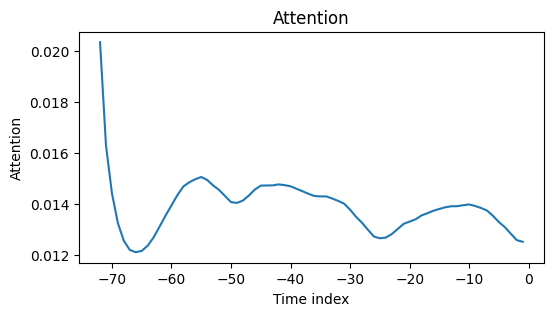

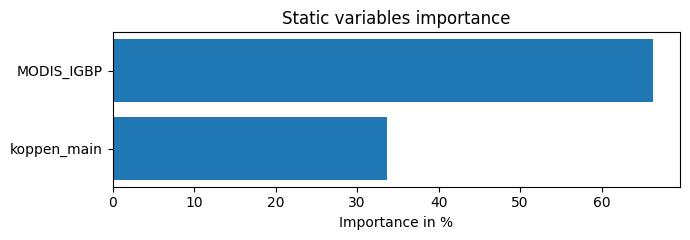

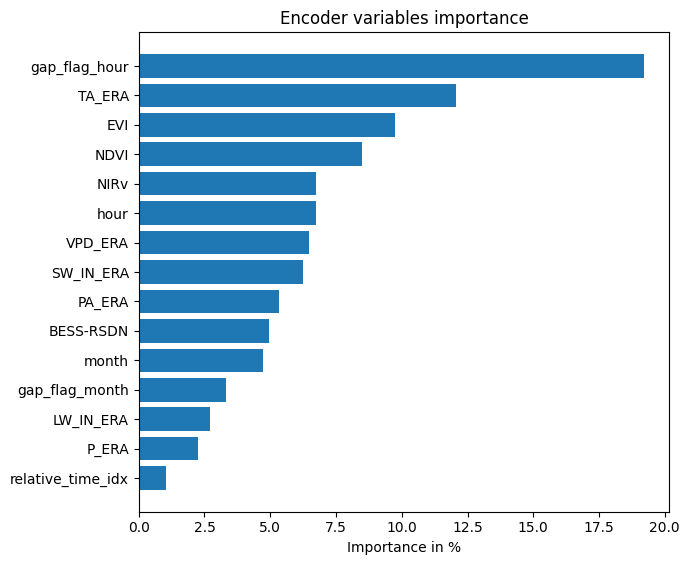

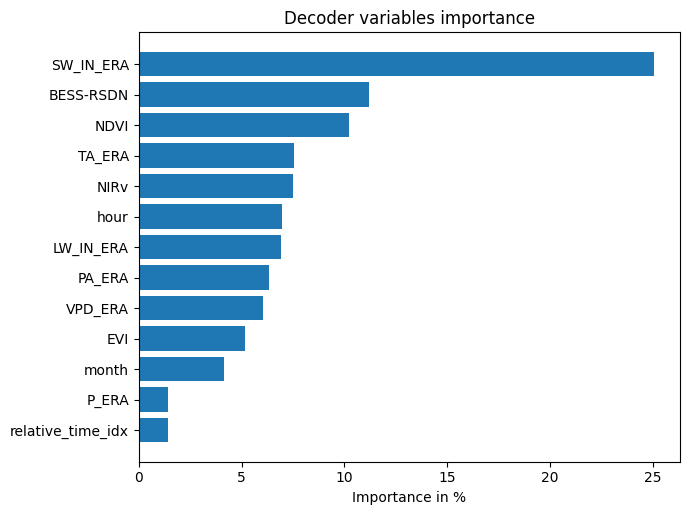

In [41]:
interpretation_sum = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation_sum)

### Plot examples

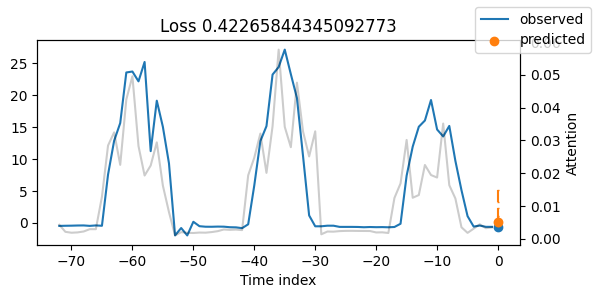

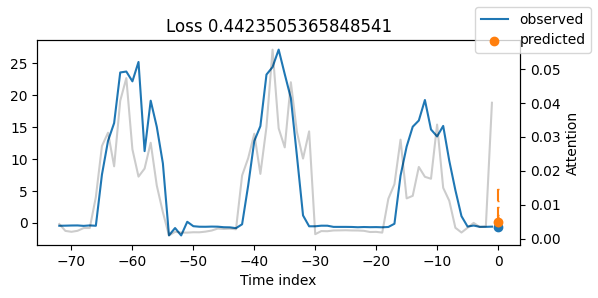

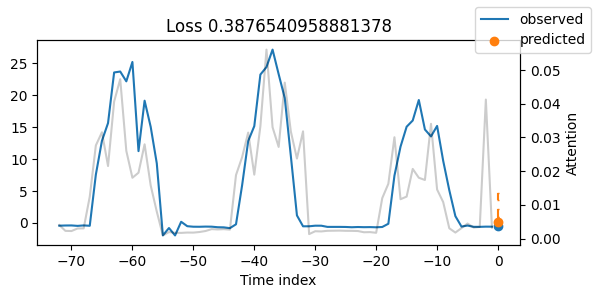

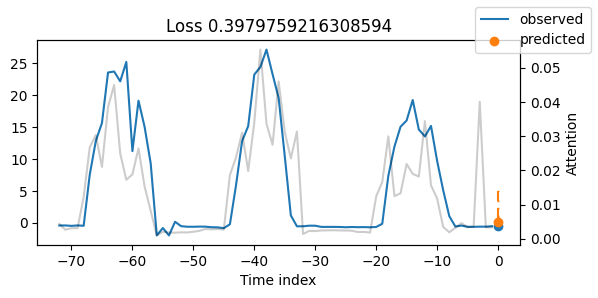

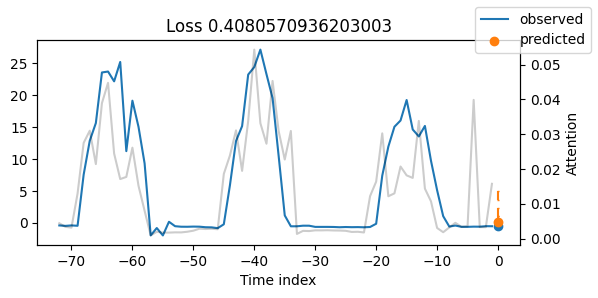

In [51]:
num_ex = 5
for idx in range(num_ex):
    best_tft.plot_prediction(x, raw_predictions, idx=idx*4, add_loss_to_title=True);

### Plot worst examples

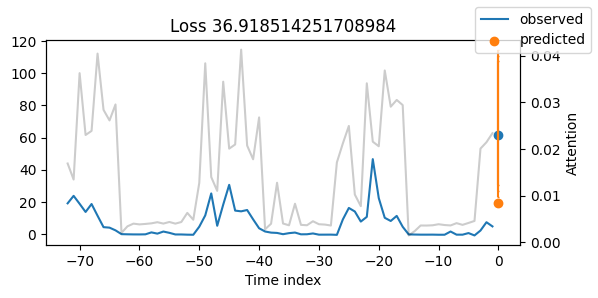

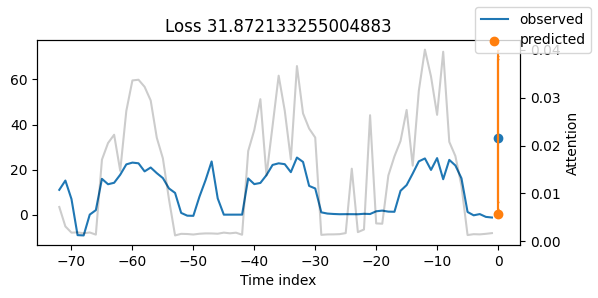

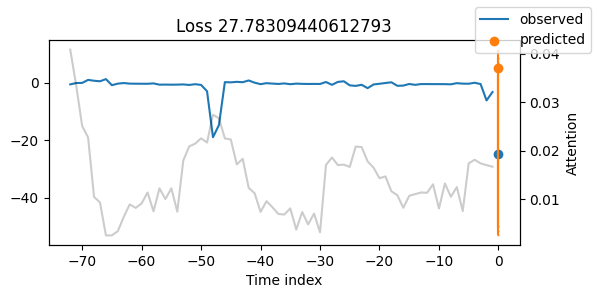

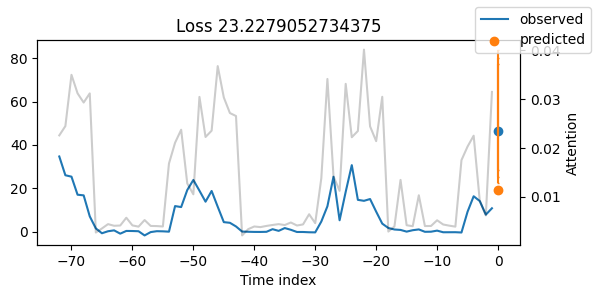

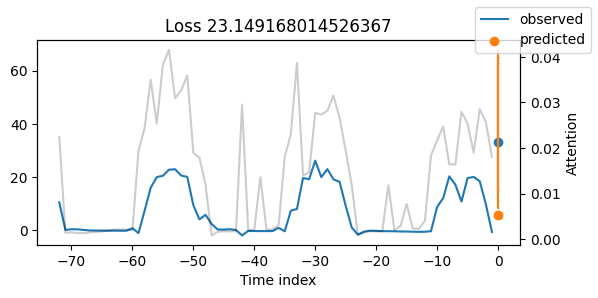

In [49]:
# Find worst RMSE scores in val set
num_bad_ex = 5
mean_losses = RMSE(reduction="none")(predictions, actuals.reshape(-1, 1)).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(num_bad_ex):  # plot 10 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=True);

## Plot best examples

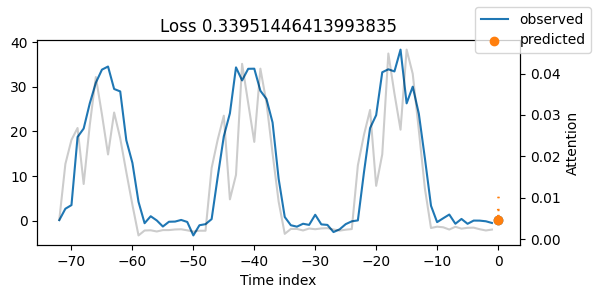

In [44]:
indices = mean_losses.argsort(descending=False)  # sort losses
for idx in range(num_bad_ex):  # plot 10 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=True);

## Get sequence of preds for each timestep vs actuals
To-Do: Make so that we can identify specific sites and specific times

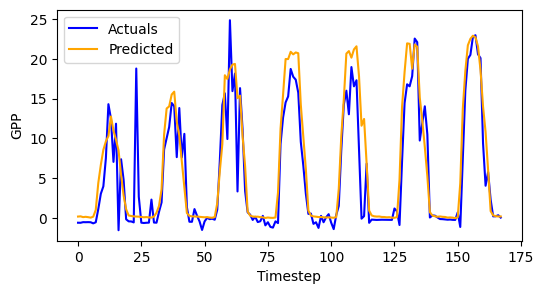

In [130]:
# Choose num hours to plot
plot_x_steps = 24*7
x_ticks = np.arange(plot_x_steps)

# Create the line plot
plt.plot(x_ticks, actuals[:plot_x_steps], color='blue', label='Actuals')
plt.plot(x_ticks, predictions[:plot_x_steps], color='orange', label='Predicted')

# Add labels and legend
plt.xlabel('Timestep')
plt.ylabel('GPP')
plt.legend()

# Show the plot
plt.show()

## Plot predictions by variable

In [ ]:
# train_preds, x_train = best_tft.predict(train, return_x=True, show_progress_bar=False)
# predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x_train, train_preds)
# best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

## Plot predictions by IGBP
To-Do: Get eval metrics by IGBP

In [160]:
known_cat=["month", "hour"]
known_real=['TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA', 'EVI', 'NDVI', 'NIRv', 'BESS-RSDN']
unknown_cat=["gap_flag_month", "gap_flag_hour"]

In [161]:
def get_feature_imps_group(raw_preds, df, group_name):
    # Get mean values
    time_means = torch.mean(raw_preds['encoder_variables'], dim=0).squeeze()
    vals = [group_name] + list(torch.mean(time_means, dim=0).numpy())
    
    # Append to df
    df.loc[len(df)] = vals
    
    return df

In [ ]:
i = 0
igbp_groups = val_df.groupby('IGBP')
igbp_fi_df = pd.DataFrame(columns= ['IGBP'] + known_cat + unknown_cat + known_real + ['relative_time_idx'])

# Loop through each group and print the mean "value"
for group_name, group_df in igbp_groups:
    print(f"\nIGBP: {group_name}")
    _, val_igbp, _ = setup_tsdataset_nogpp_slim(train_df, group_df, None, ENCODER_LEN)
    raw_prediction_igbp = best_tft.predict(val_igbp, mode="raw", return_x=False, show_progress_bar=False)
        
    # Interpret Outputs
    interpretation_sum = best_tft.interpret_output(raw_prediction_igbp, reduction="sum")
    best_tft.plot_interpretation(interpretation_sum)
    
    # Append feature imps to df
    igbp_fi_df = get_feature_imps_group(raw_prediction_igbp, igbp_fi_df, group_name)
    
    # Temp break to test a few example IGBPs
    i +=1
    if i == 3:
        break
        
igbp_fi_df.head()


IGBP: CRO


### Plot predictions by Hour of day


 Hour: 1

 Hour: 12

 Hour: 16


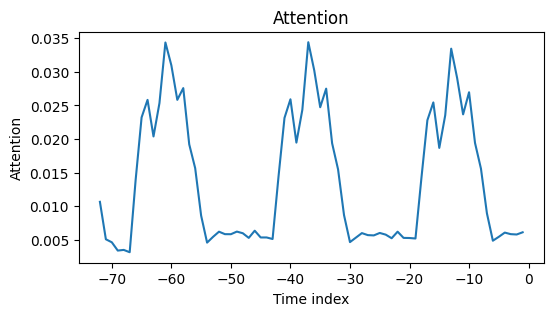

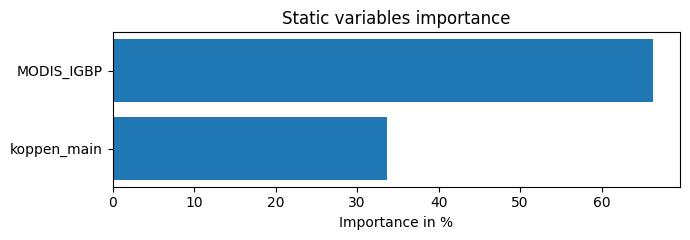

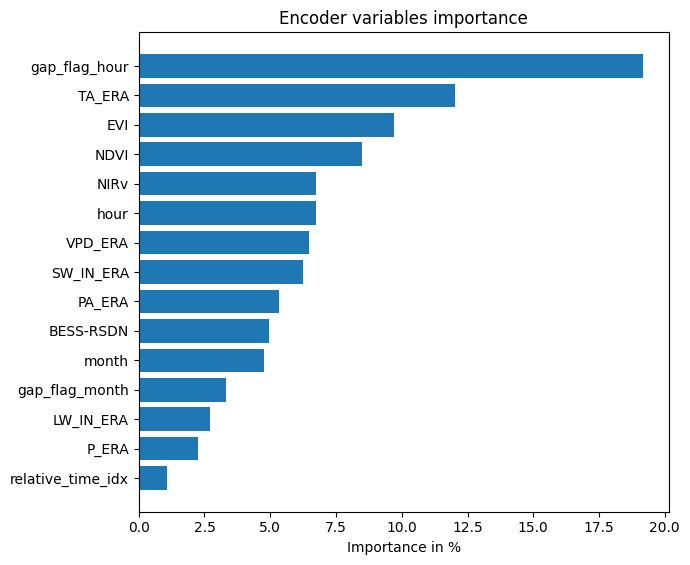

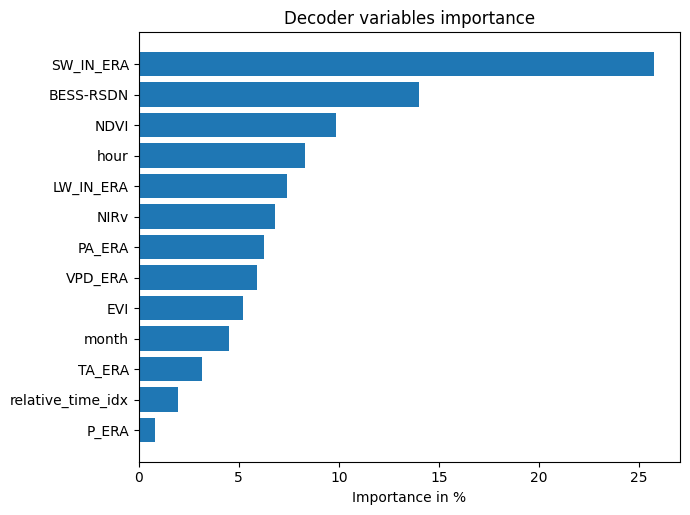

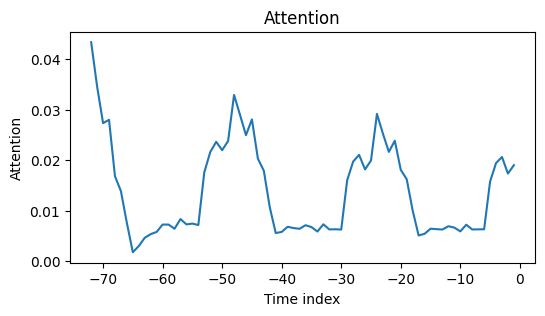

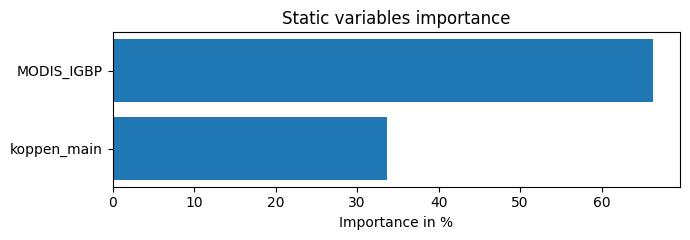

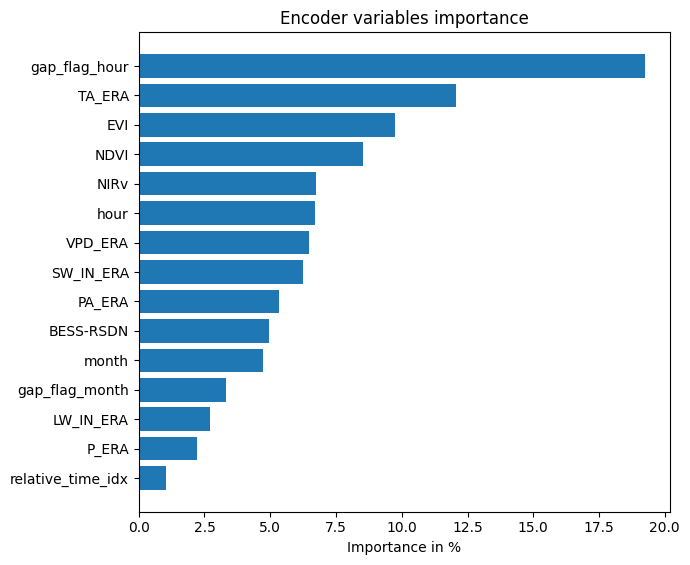

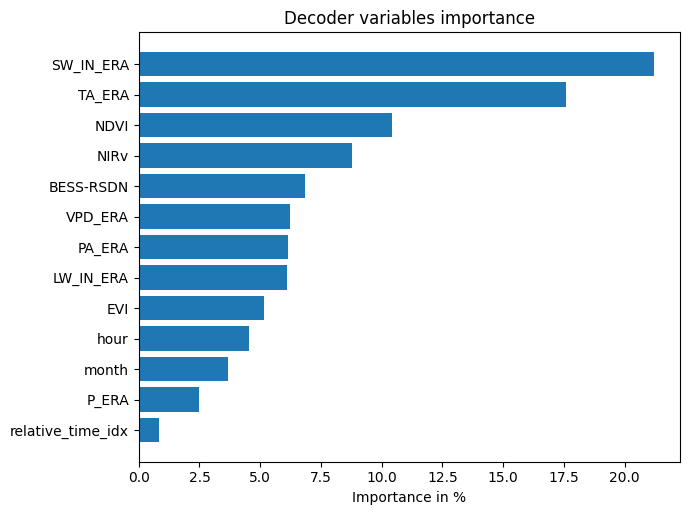

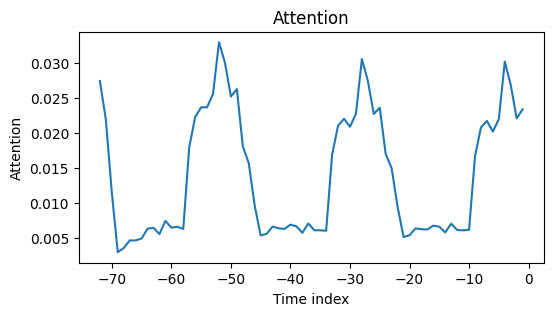

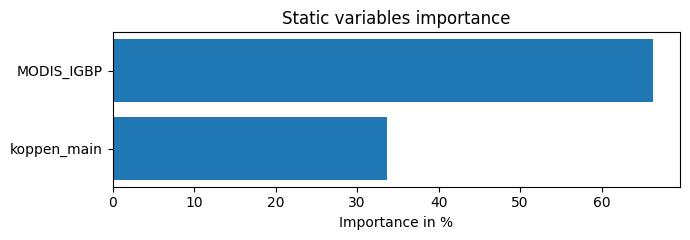

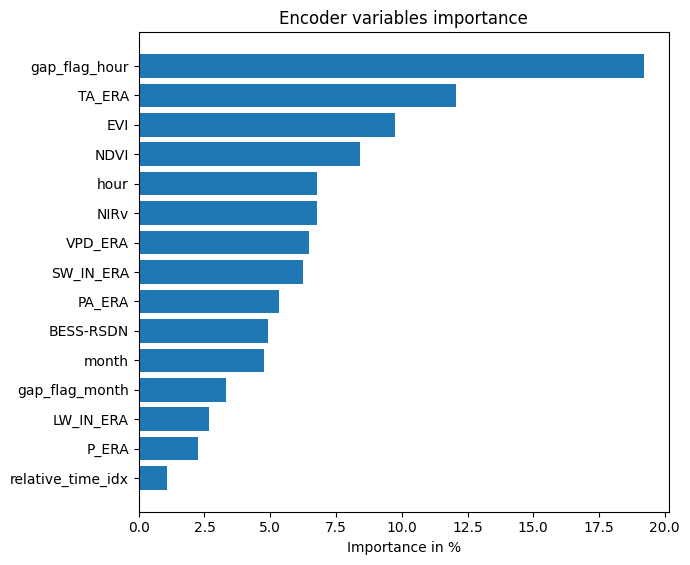

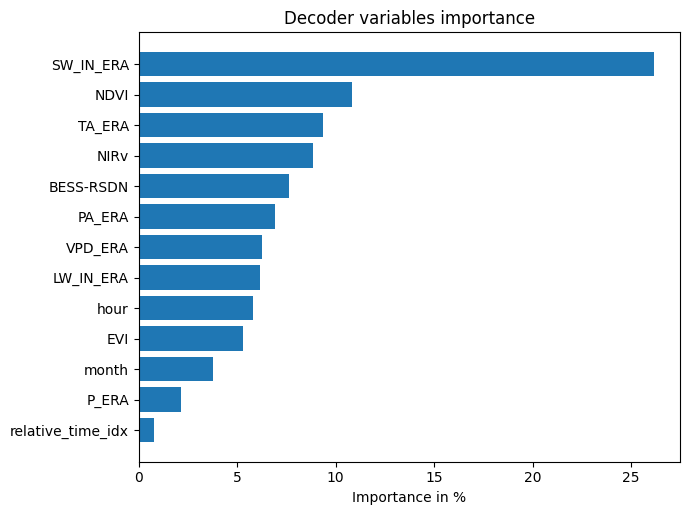

In [150]:
# Init Hour Feature Importance DF
hour_fi_df = pd.DataFrame(columns= ['IGBP'] + known_cat + unknown_cat + known_real + ['relative_time_idx'])

i = 0
for choose_hour in ['1', '12', '16']:
    print(f"\n Hour: {choose_hour}")
    # Get timesteps for the hour
    hour_timesteps = dec_ind_df.loc[dec_ind_df['hour']==choose_hour, 'time_idx_first_prediction'].values
    
    # Get preds for the given hour of day
    raw_prediction_hour = best_tft.predict(
        validation.filter(lambda x: (x.time_idx_first_prediction.isin(hour_timesteps))),
        mode="raw",
        return_x=False)
    
    # Interpret Outputs
    interpretation_sum = best_tft.interpret_output(raw_prediction_hour, reduction="sum")
    best_tft.plot_interpretation(interpretation_sum)
    
    # Append Feature Importances to DF
    hour_fi_df = get_feature_imps_group(raw_prediction_hour, hour_fi_df, choose_hour)
    
    # Temp break for testing
    i += 1
    if i == 3:
        break
        
hour_fi_df.head()

## Prediction-Level Attention and Feature Importance
To-Do: Find specific timesteps to tell a story

In [151]:
interpretation_none = best_tft.interpret_output(raw_predictions, reduction="none")

In [152]:
# Determine which features align to "encoder_variables", validate against imoprtances above
enc_var_means = torch.mean(interpretation_none['encoder_variables'], dim=0).numpy()
enc_var_names = known_cat + unknown_cat + known_real + ['relative_time_idx']
feature_imp_dict = dict(zip(enc_var_names, enc_var_means))
feature_imp_dict

{'month': 0.047419373,
 'hour': 0.0672771,
 'gap_flag_month': 0.033083137,
 'gap_flag_hour': 0.19209804,
 'TA_ERA': 0.120516814,
 'SW_IN_ERA': 0.062383708,
 'LW_IN_ERA': 0.027075365,
 'VPD_ERA': 0.064754,
 'P_ERA': 0.022391964,
 'PA_ERA': 0.05328697,
 'EVI': 0.09732815,
 'NDVI': 0.08495531,
 'NIRv': 0.067507215,
 'BESS-RSDN': 0.049364902,
 'relative_time_idx': 0.010557951}

### Investigate feature importances for 1 prediction

In [155]:
# Get top timestep for pred 1
pred_ind = 0
ind = raw_predictions["encoder_attention"][pred_ind][0][0].argmax()
print(f"Top encoder attention index is for pred {pred_ind} is {ind-ENCODER_LEN}")

# Which feature is most important at this prediction step?
enc_vars_at_ind = raw_predictions["encoder_variables"][pred_ind][ind]
enc_ind = torch.argmax(enc_vars_at_ind)
feat_ind = enc_var_names[enc_ind]
print(f"Most important feature at index {ind-ENCODER_LEN} is {feat_ind}")

Top encoder attention index is for pred 0 is -36
Most important feature at index -36 is NDVI


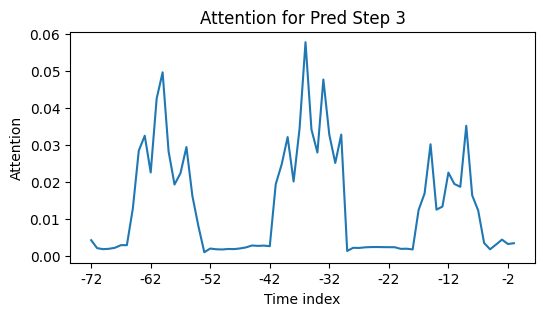

In [156]:
# attention
fig, ax = plt.subplots()
attention = interpretation_none["attention"][pred_ind].detach().cpu()
attention = attention / attention.sum(-1).unsqueeze(-1)
ax.plot(attention)
ax.set_xlabel("Time index")
ax.set_ylabel("Attention")
ax.set_title(f"Attention for Pred Step {i}")
xticks_locations = range(0, len(attention), 10)
xticks_labels = range(-len(attention), 0, 10)
plt.xticks(xticks_locations, xticks_labels)
plt.show()

In [157]:
# Pick one step, find the highest attention timestep, find 
pred_feat_importances = torch.mean(raw_predictions["encoder_variables"][pred_ind], dim=0)[0].numpy()

print(f"Prediction-Level Feature Importances at Pred Step {pred_ind}, across all encoder inds")
pred_feature_imp_dict = dict(zip(enc_var_names, pred_feat_importances))
sorted_dict = dict(sorted(pred_feature_imp_dict.items(), key=lambda item: item[1], reverse=True))
print(sorted_dict)

Prediction-Level Feature Importances at Pred Step 0, across all encoder inds
{'gap_flag_hour': 0.19956596, 'SW_IN_ERA': 0.17962879, 'NDVI': 0.1036113, 'BESS-RSDN': 0.08509452, 'NIRv': 0.0745492, 'hour': 0.06805203, 'VPD_ERA': 0.060291395, 'month': 0.05624755, 'TA_ERA': 0.04564881, 'PA_ERA': 0.045528546, 'gap_flag_month': 0.028593242, 'LW_IN_ERA': 0.020662371, 'P_ERA': 0.011690492, 'EVI': 0.010603456, 'relative_time_idx': 0.0102322865}
